# Estimating catchment sensitivity function

* Prerequisite: 1. Jupyter (included in Anaconda python)
                  (python -m pip install jupyter)
                  
                2. Uncertainties package
                 
                  (pip install uncertainties)







* How to run

  1. Open terminal (Mac) or command prompt (Windows)
  2. Change directory to the folder that contains the downloaded files
  3. Type "jupyter notebook CSF.ipynb" and press enter

## 1. Load dataset

Load Lower Haften (Wales) dataset used in Wilusz et al., 2017, WRR

In [1]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('LH.csv', parse_dates=True, index_col = 0) #load dataset
print (dataset)
#pd.DataFrame(dataset) #print dataset

j = dataset['J [mm/day]'].values
q = dataset['Q [mm/day]'].values
et = dataset['ET [mm/day]'].values
t = np.arange(len(q))
qqet = q / (q+et)

            J [mm/day]  Q [mm/day]  ET [mm/day]
1993-01-01    0.000000    1.360458     0.248194
1993-01-02    0.000000    1.270483     0.219758
1993-01-03    5.000000    1.199162     0.122667
1993-01-04    6.000000    1.531534     0.366585
1993-01-05   16.500000    4.022899     0.404492
1993-01-06    5.750000    3.245933     0.088048
1993-01-07   13.250000    4.089545     0.196735
1993-01-08    0.000000    4.291014     0.390126
1993-01-09   38.500000   17.256922     0.299100
1993-01-10   46.250000   34.928648     0.331628
1993-01-11   10.750000   15.512631     0.398107
1993-01-12    4.500000    7.665260     0.318190
1993-01-13   21.500000   10.109589     0.134916
1993-01-14    4.250000    8.234497     0.536618
1993-01-15   25.250000   16.483299     0.571062
1993-01-16    6.250000    9.010458     0.320923
1993-01-17    6.250000    8.180296     0.488902
1993-01-18    5.250000    6.055919     0.373365
1993-01-19   34.000000   13.305193     0.271195
1993-01-20   40.250000   30.546226     0

## 2. Plot dataset

Plot rainfall, discharge, and evapotranspiration time series

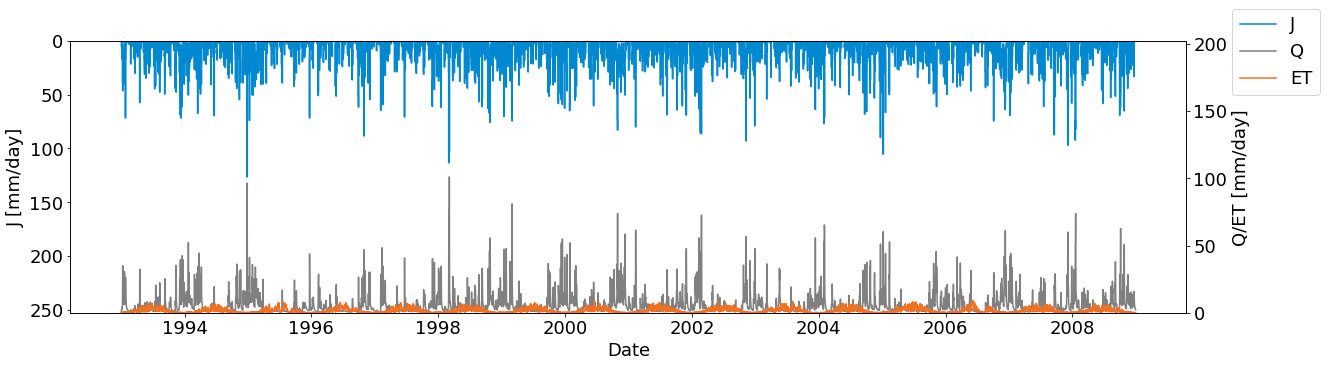

In [2]:
%matplotlib inline

import matplotlib
font = {'size'   : 18}    
matplotlib.rc('font', **font)

import matplotlib.pylab as plt
from module_hydrology import plot_JQET

figM = plt.figure(1, figsize = (20,5))
ax = figM.add_subplot(111)
ax, ax2, _,_,_ = plot_JQET(dataset.index,dataset['J [mm/day]'],dataset['Q [mm/day]'],dataset['ET [mm/day]'],ax,fill_bet_J = True)
figM.legend()
ax.set_xlabel('Date')
ax.set_ylabel('J [mm/day]')
ax2.set_ylabel('Q/ET [mm/day]');


## 3. Define periods

The variable $\textbf{exclude}$ determine which period to exclude.

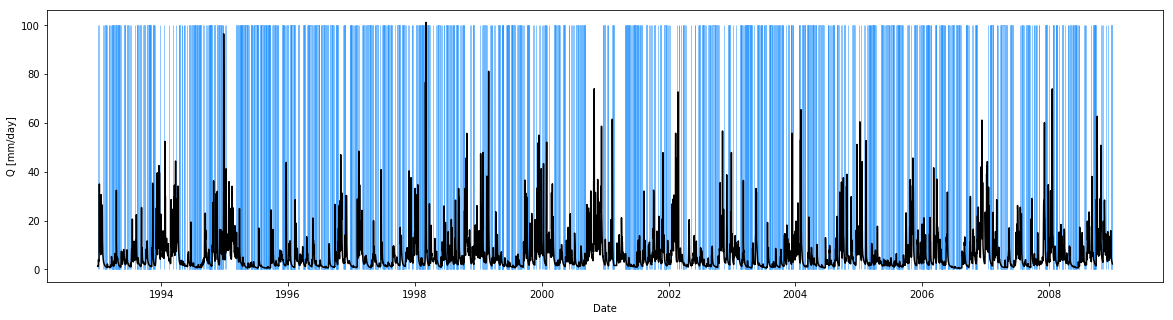

In [3]:
import module_RecessionAnalysis as gq

#Exclude period when j > 0
exclude = j > 0.0

#Exclude period j > 0 or  Dq >= 0
#Dq = np.append(np.diff(q),False)
#exclude = np.logical_or(j > 0.0, Dq >= 0.0)

gq_result = gq.init(q, t, correction_ET = qqet, verbose=False)
gq_result.def_period(exclude)

figM = plt.figure(2, figsize = (20,5))
ax = figM.add_subplot(111)
ax.plot(dataset.index, q, 'k')
for event in gq_result.events:  
    ax.fill_between(dataset.index[event.t],np.zeros_like(event.t),np.ones_like(event.t)*100.,step="pre",alpha = 0.5, color = 'dodgerblue', label = 'Selected period')
    
ax.set_ylabel('Q [mm/day]')
ax.set_xlabel('Date');
#figM.legend([p])

## 4. Estimating dQ/dt

The variable $\textbf{method_dqdt}$ determines methods to estimate dQ/dt. Currently available options are listed in the table below.




|  |   Direction    | dQ/dt  |  Q  | 
|-|-----------|------|--|
| B1 |   Backward  | $\frac{Q(t) - Q(t-\Delta t)}{\Delta t}$| $\frac{Q(t-\Delta t) + Q(t)}{2}$ | 
| C1 |   Centered  | $\frac{Q(t+\Delta t) - Q(t-\Delta t)}{2 \Delta t}$ | $Q(t)$ | 

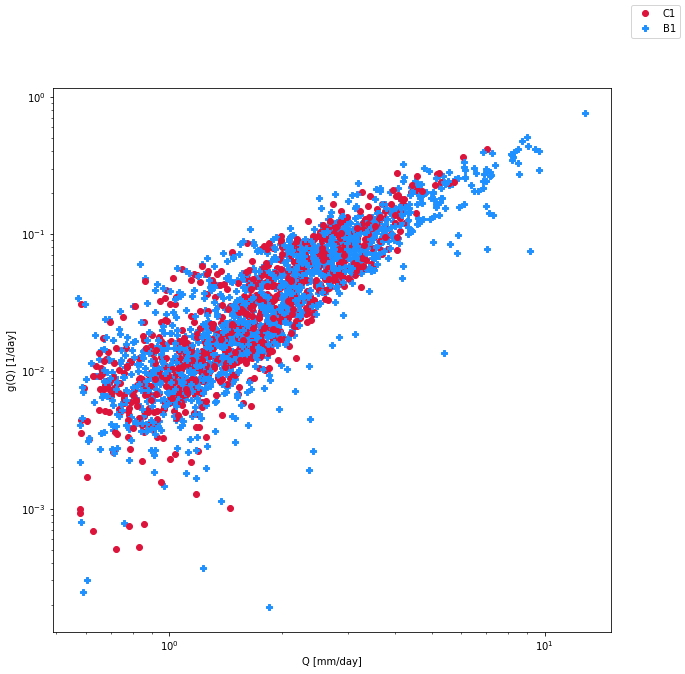

In [4]:
#method_dqdt = ['C1']
method_dqdt = ['C1', 'B1']

method_dqdt_marker = ['o','P'] 
method_dqdt_color = ['crimson','dodgerblue'] 

gq_result.est_dqdt(method = method_dqdt)

figM = plt.figure(3, figsize = (10,10))
ax = figM.add_subplot(111)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('g(Q) [1/day]')
ax.set_xlabel('Q [mm/day]')

p = {}
for event in gq_result.events: 
    for idx_method, item_method in enumerate(method_dqdt):
        p[item_method] = ax.plot(event.qh[item_method], event.dq_dt[item_method]*event.corh[item_method]/event.qh[item_method],  marker = method_dqdt_marker[idx_method], color = method_dqdt_color[idx_method],  ls = 'None', label = item_method)                

figM.legend(p);

## 5. Fitting functions

Fitting functions to the above data scatter.
Two supported functional forms are:

* $\ln g(Q) = a + b \ln Q$

* $\ln g(Q) = a + b \ln Q + c (\ln Q)^2$

Set the variable $\textbf{regression_function}$ as $\textbf{ln(-dqdt) = a + b * ln(Q)}$ to use the first one,
and set the variable as $\textbf{ln(-dqdt) = a + b * ln(Q)}$ to use the latter form.


Furthermore, three fitting methods are available.
The variable $\textbf{method_regression}$ selects fitting methods. Available methods are:

* $\textbf{ols}$: Ordinary least square method

* $\textbf{wls}$: Weighted least square method (based on the method of Kirchner, 2009, WRR)

* $\textbf{quantile}$: Quantile regression (Thomas et al., 2015, JoH)
    

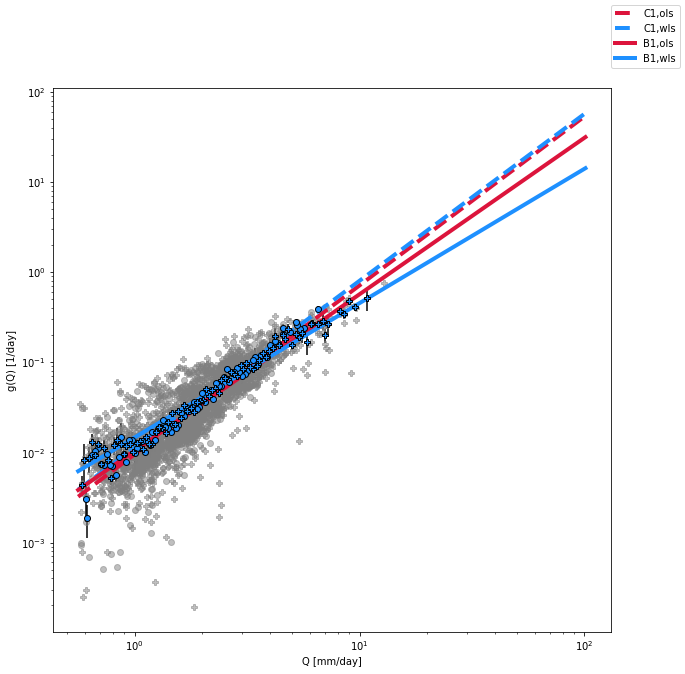

In [5]:
regression_function = 'ln(-dqdt) = a + b * ln(Q)' #Power-law
#regression_function = 'ln(-dqdt) ~ a + b * ln(Q) + c * ln(Q)^2' #Kirchner, 2009
method_regression = ['ols', 'wls']


method_regression_color = ['crimson','dodgerblue']
method_dqdt_ls = ['dashed','-']

import itertools
method = list(itertools.product(method_dqdt, method_regression))
method_T = np.transpose(method)
method_name = [x+','+y for x, y in zip(method_T[0], method_T[1])]
method_ls = list(itertools.product(method_dqdt_ls, method_regression_color))


from init_funcs import *
if regression_function  == 'ln(-dqdt) = a + b * ln(Q)':
    params_init = (1,1)
    g_func = g_func_pow
    sq_func = SQ_power
    param_n = 2
elif regression_function  == 'ln(-dqdt) ~ a + b * ln(Q) + c * ln(Q)^2':
    params_init = (1,1,1) 
    g_func = g_func_2nd
    param_n = 3     
    sq_func = SQ_2nd_order #[MSK] ERFi?  #depending on a paramter...
else:
    logger.error('wrong regression function')
    
    
gq_result.getgf(g_func, p0=params_init, method = method, func = regression_function) #p0 is the initial values for the regression analysis 
    
figM = plt.figure(4, figsize = (10,10))
ax = figM.add_subplot(111)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('g(Q) [1/day]')
ax.set_xlabel('Q [mm/day]')

if np.nanmin(q)>0.0:              
    qarr = np.geomspace(np.nanmin(q), np.nanmax(q),1000) 
else:
    qarr = np.geomspace(0.0000000001, np.nanmax(q),1000)

    
for rec in gq_result.events:
    for idx_method, item_method in enumerate(method_dqdt):
        ax.plot(rec.qh[item_method], rec.dq_dt[item_method]*rec.corh[item_method]/rec.qh[item_method],  marker = method_dqdt_marker[idx_method], alpha=0.5, color = 'grey', ls = 'None')

for s, item_method in enumerate(method_name):
    ax.plot(qarr, gq_result.g_func_set[item_method](qarr
                                                   ), ls = method_ls[s][0], color = method_ls[s][1], lw = 4, label = item_method) #seems like this a kind of the master recession curve          

    if 'wls' in item_method:  
        for idx_dqdt,item_dqdt in enumerate(method_dqdt):
            if item_dqdt in item_method:
                pp = idx_dqdt

        x_Kirchner = np.array(gq_result.g_func_prop_wls[(item_method,'gfuncx')])
        y_Kirchner = np.array(gq_result.g_func_prop_wls[(item_method,'gfuncy')])
        std_err_Kirchner = np.array(gq_result.g_func_prop_wls[(item_method,'std_err')])
        std_err_divQ_Kirchner = np.array(gq_result.g_func_prop_wls[(item_method,'bin_stderr_divQs')])

        ax.errorbar(x_Kirchner,y_Kirchner,yerr=std_err_divQ_Kirchner, fmt = method_dqdt_marker[pp], mfc = 'dodgerblue', mec = 'k', color = 'k')

            
figM.legend();


## 6. Parameter confidence intervals

* Uncertainty estimation which requires package $\textbf{uncertainties}$

,0,1
"B1,ols",0.0105+/-0.0010,1.74+/-0.11
"B1,wls",0.0147+/-0.0021,1.49+/-0.07
"C1,ols",0.0096+/-0.0010,1.87+/-0.16
"C1,wls",0.0113+/-0.0023,1.85+/-0.13


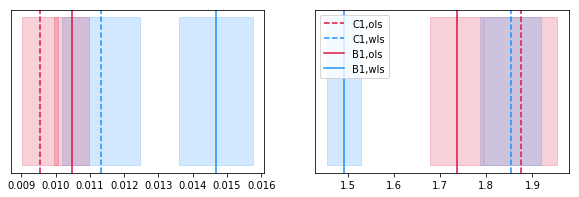

In [6]:
params_kind = ['mean','low','high']
params_set = {}
figM, ax = plt.subplots(nrows=1, ncols=param_n, sharex='col', num = 5, figsize = (10,3)) 

# [MSK] Need to consider the case where uncertainties and mpmath are not installed.

from uncertainties import ufloat

params_uncert_set = {}
for s, item_method in enumerate(method_name):    
    for k, item_params_kind in enumerate(params_kind):
        params_set[(item_method,item_params_kind)] = gq_result.g_func_params_set[(item_method,item_params_kind)]

    params_uncert = {}
    params_uncert_set[item_method] = {}
    for k in range(param_n): #maybe this for can be removed
        params_uncert[k] = ufloat(params_set[(item_method,'mean')][k], params_set[(item_method,'high')][k] - params_set[(item_method,'low')][k])
        params_uncert_set[item_method][k] = params_uncert[k]
        ax[k].axvline(params_set[(item_method,'mean')][k],ls = method_ls[s][0], color = method_ls[s][1], label = item_method)
        ax[k].fill_betweenx( [0,1],[params_set[(item_method,'low')][k],params_set[(item_method,'low')][k]], [params_set[(item_method,'high')][k],params_set[(item_method,'high')][k]], color = method_ls[s][1], alpha = 0.2)        
        ax[k].set_yticks([])
        
ax[k].legend()
pd.DataFrame.from_dict(params_uncert_set).T

## 7. Storage-discharge relationship

Storage-discharge relationship can be estimated from the catchment sensitivity function as [Kirchner, 2009, WRR]:

$S(Q) - S(Q_{min}) = \int_{Q_{min}}^{Q} dS(Q) = \int_{Q_{min}}^{Q} \frac{1}{g(Q)}dQ$

Currently, uncertainty bounds cannot be estimated if $\ln g(Q) = a + b \ln Q + c (\ln Q)^2$.

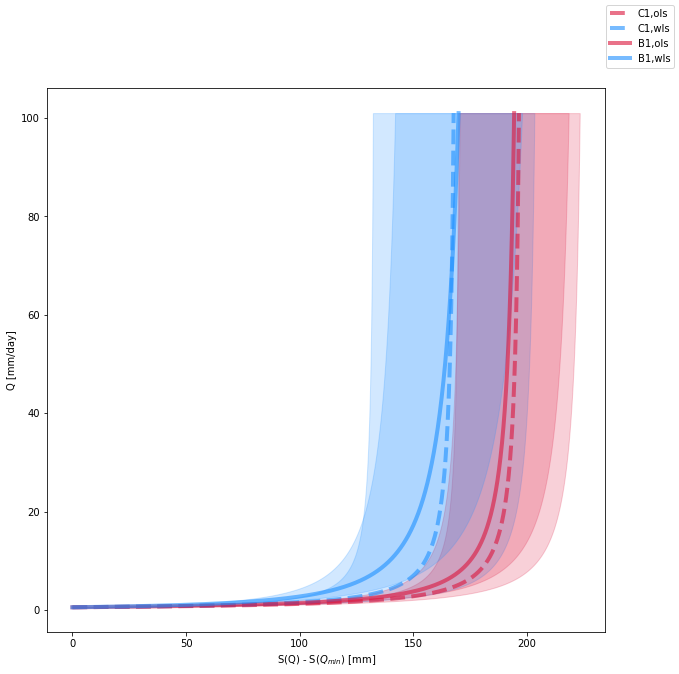

In [7]:
from uncertainties import unumpy

figM = plt.figure(6, figsize = (10,10))
ax = figM.add_subplot(111)

for s, item_method in enumerate(method_name):    
    ax.plot(sq_func(qarr,params_set[(item_method,'mean')])   , qarr, ls = method_ls[s][0], color = method_ls[s][1], lw = 4, alpha = 0.6, label = item_method) #how did you estimated S?

    params_uncert = {}
    for k in range(param_n): #maybe this for can be removed
        params_uncert[k] = ufloat(params_set[(item_method,'mean')][k], params_set[(item_method,'high')][k] - params_set[(item_method,'low')][k])
        
    if regression_function == 'ln(-dqdt) = a + b * ln(Q)':
        SQ_uncert = sq_func(qarr,params_uncert) #- sq_func(qarr[0],params_uncert)
        SQ_uncert_nominal = unumpy.nominal_values(SQ_uncert)
        SQ_uncert_stddevs = unumpy.std_devs(SQ_uncert)    

        ax.fill_betweenx( qarr,SQ_uncert_nominal - SQ_uncert_stddevs, SQ_uncert_nominal + SQ_uncert_stddevs, color = method_ls[s][1], alpha = 0.2)
ax.set_xlabel('S(Q) - S($Q_{min}$) [mm]')
ax.set_ylabel('Q [mm/day]')
figM.legend();

## 8. Rainfall-runoff model

Running Rainfall-runoff model based on the catchment senstivity function $g(Q)$.

$\frac{dQ}{dt} = \frac{dQ}{dS}\frac{dS}{dt} = g(Q)(P - E - Q)$

Plot modeled results and generate a table with an efficiency measure defined in the variable $\textbf{efficiency_measure}$.
Available efficiency measures are: $\textbf{'NSE'}$, $\textbf{'KGE'}$.

,Q,Log Q
"C1,ols",0.780374,0.880297
"C1,wls",0.758390,0.846441
"B1,ols",0.834896,0.882506
"B1,wls",0.896849,0.841681


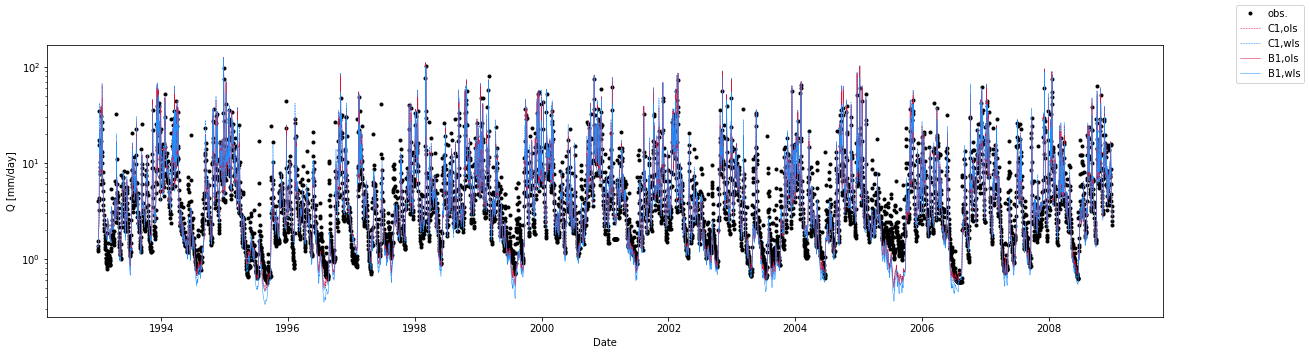

In [8]:
efficiency_measure = 'KGE' #KGE or NSE

from scipy.integrate import odeint

from module_hydrology import Bucket_ode
from module_hydrology import one_minus_em

figM = plt.figure(7, figsize = (20,5))
ax = figM.add_subplot(111)
ax.plot(dataset.index, q,'.',label = 'obs.', color = 'k')

tidx = np.linspace(0,len(dataset.index)-1,len(dataset.index))

efficiency = np.zeros((len(method_name), 2))
for s, item_method in enumerate(method_name):    
    Qx = odeint(Bucket_ode,q[0],tidx,args = (params_set[(item_method,'mean')],len(tidx),dataset['J [mm/day]'].values,et,1.0,g_func),hmax = 6./24.).flatten()    
    ax.plot(dataset.index, Qx,ls = method_ls[s][0], color = method_ls[s][1],label = item_method, lw = 0.5)    
    efficiency[s][0] = 1.0 - one_minus_em(q, Qx, efficiency_measure = efficiency_measure, log_trans = False)
    efficiency[s][1] = 1.0 - one_minus_em(q, Qx, efficiency_measure = efficiency_measure, log_trans = True)
    
ax.set_yscale('log')
ax.set_ylabel('Q [mm/day]')
ax.set_xlabel('Date')
figM.legend()

pd.DataFrame(efficiency, columns=["Q", "Log Q"], index = method_name)